### Class Examples for Encoding/Decoding Lecture VI on Information Theory

In [7]:
# Read in modules
from matplotlib import pyplot as plt
import numpy as np
import compneuro as stg

In [8]:
def generate_trains(
    rate, N_trials, T, tau_ref=0, tau_burst=0, prob_burst=0, prob_end=0
):
    """
    Generate N_trials spike trains at rate for T time.

    Parameters
    ----------
    rate : float
        Baseline firing rate of the spike train
    N_trials : integer
        Number of spike trains to generate
    T : float
        Length of time for spike train (seconds)
    tau_ref : float
        (optional) Refractory period, shortest time between spikes
    tau_burst : float
        (optional) Minimum time between consecutive bursts
    prob_burst : float
        (optional) Probability to enter a burst.
    prob_end : float
        (optional) Probability to end the burst.

    Returns
    -------
    List of np.array
        List containing N_trials number of spike train as np.ndarray
    """
    # empty list to hold all spike trains
    trains = []

    # iterate for N_trials to generate spike trains
    for _ in range(N_trials):
        trains.append(
            stg.poisson_burst_method2(
                rate,
                0,
                T,
                tau_ref=tau_ref,
                tau_burst=tau_burst,
                prob_burst=prob_burst,
                prob_end=prob_end,
            )
        )
    return trains


def spike_counts(trains):
    """
    Returns number of spikes in spike train.

    Parameters
    ----------
    trains : list
        List of spike trains

    Returns
    -------
    np.ndarray
        array of spike counts for each spike train
    """
    return np.array([len(st) for st in trains])

Let's compute $H(R)$ from a spike count distribution. Remember that $H(R)$ is the uncertainty or variability of neural response across all stimuli, based on probability distribution $p(r)$:

$H(R) = -\sum_r p(r) \log_2 p(r)$

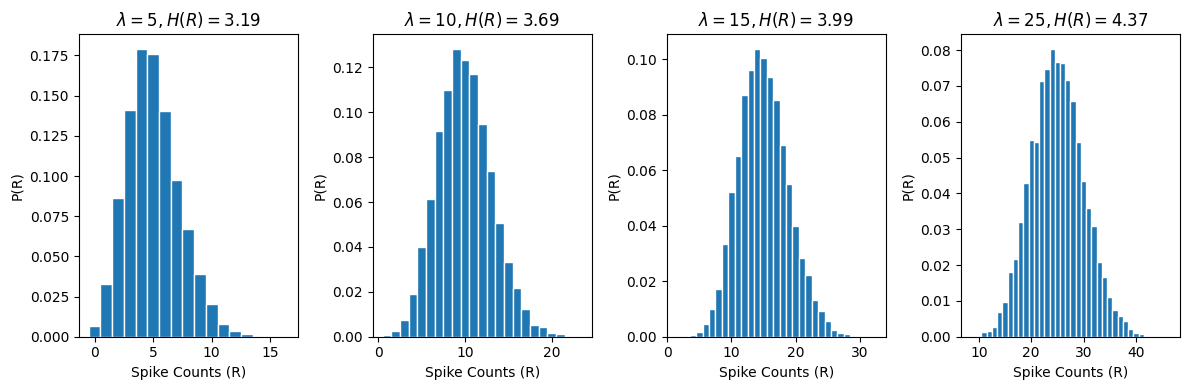

In [9]:
# Rates, trials, and recoding time
rates = [5, 10, 15, 25]
N_trials = 10000
T = 1

# Iterate through rates
# Generate spike trains an determine spike counts
all_spike_counts = []
for rate in rates:
    all_spike_counts.append(spike_counts(generate_trains(rate, N_trials, T)))

# Plot the different p(r) distributiosn with corresponding H(R)
fig, ax = plt.subplots(1, 4, figsize=(12, 4), tight_layout=True)
axes = [ax[i] for i in range(4)]
for i, r in enumerate(rates):

    # Determine frequency of all unique values
    vals, freqs = np.unique(all_spike_counts[i], return_counts=True)

    # Calculate probability of spike counts
    p_r = freqs / freqs.sum()

    # Calculate H(R) based on p(r)
    h_r = -(p_r * np.log2(p_r)).sum()

    # Plot histogram of values and probabilities
    axes[i].bar(vals, p_r, width=1, edgecolor="w")
    axes[i].set_title(f"$\lambda={r}, H(R)={h_r:.02f}$")
    axes[i].set_xlabel("Spike Counts (R)")
    axes[i].set_ylabel("P(R)")
plt.show()

Great! But how does this change based on the number of simulations for different rates?

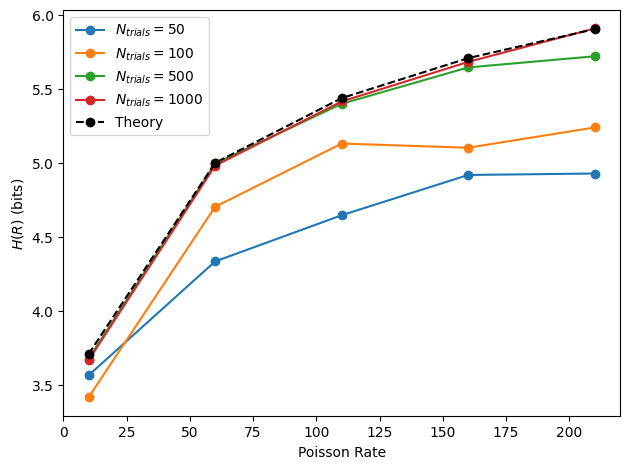

In [10]:
# Number of trial simulations to test
Nts = [50, 100, 500, 1000]

# Large figure to plot results
fig, ax = plt.subplots(1, 1, tight_layout=True)

# Iterate through all trials
for N_trials in Nts:

    # For list of rates, generate spike counts
    all_spike_counts = []
    rates = np.arange(10, 250, 50)
    for rate in rates:
        all_spike_counts.append(spike_counts(generate_trains(rate, N_trials, T)))

    # Determine H(R) for each rate
    h_rs = np.zeros(len(rates))
    for i, r in enumerate(rates):
        vals, freqs = np.unique(all_spike_counts[i], return_counts=True)
        p_r = freqs / freqs.sum()
        h_rs[i] = -(p_r * np.log2(p_r)).sum()

    # Plot H(R) as function of rate for given number of trials
    ax.plot(rates, h_rs, marker="o", label="$N_{trials}=$" + f"{N_trials}")

# Plot theoretical value of H(R) for given rate
ax.plot(
    rates,
    0.5 * np.log2(2 * np.pi * rates * np.exp(1) * T),
    marker="o",
    color="k",
    ls="--",
    label="Theory",
)
ax.legend()
ax.set_xlabel("Poisson Rate")
ax.set_ylabel("$H(R)$ (bits)")
plt.show()

Now that we've seen how to measure the uncertainty for all responses, what about the uncertainty remaining after knowing the stimulus?

We can determine the conditional entropy, or:

$H(R|S) = -\sum_sp(s)\sum_{r}p(r|s)\log_2p(r|s)$

which measures the ambiguity or noise in the response with given simuli.

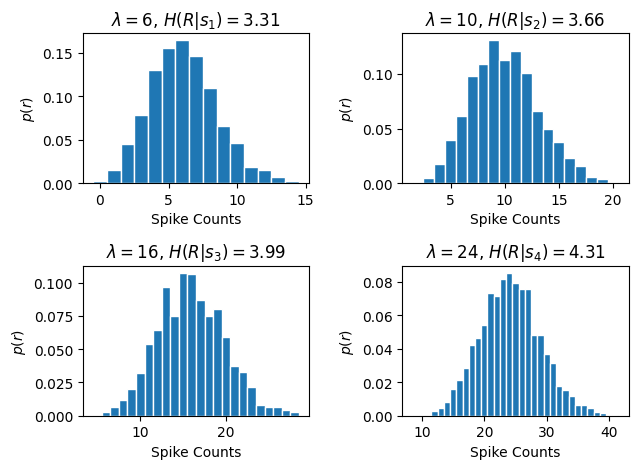

In [11]:
# Determine probability of seeing each stimulus
p_s = [0.25, 0.25, 0.25, 0.25]

# Stimulus rates, number of trials, recoding time
stimuli_rates = [6, 10, 16, 24]
N_trials = 1500
T = 1

# Determine spike counts for all stimuli
all_spike_counts = []
for rate in stimuli_rates:
    all_spike_counts.append(spike_counts(generate_trains(rate, N_trials, T)))

# Set up figure to visualize p(r) for each stimuli
fig, ax = plt.subplots(2, 2, tight_layout=True)
axes = [ax[i, j] for i in range(2) for j in range(2)]

# Iterate through each response given a stimuli
# Calculate H(R|S)
h_r_given_s = 0
for i, priors in enumerate(p_s):

    # Determine p(r) as before
    vals, freqs = np.unique(all_spike_counts[i], return_counts=True)
    p_r = freqs / freqs.sum()

    # Plot p(r)
    axes[i].bar(vals, p_r, width=1, edgecolor="w")
    axes[i].set_title(
        f"$\lambda = {stimuli_rates[i]}$, $H(R|s_{i+1}) = {-(p_r * np.log2(p_r)).sum():.02f}$"
    )
    axes[i].set_xlabel("Spike Counts")
    axes[i].set_ylabel("$p(r)$")

    # Calcuate H(R|s_i) where s_i is current stimulus
    h_r_given_s += -(p_r * np.log2(p_r)).sum() * priors
plt.show()

Now that we have $H(R|S)$ we can combine all the responses and determine $H(R)$ like before.

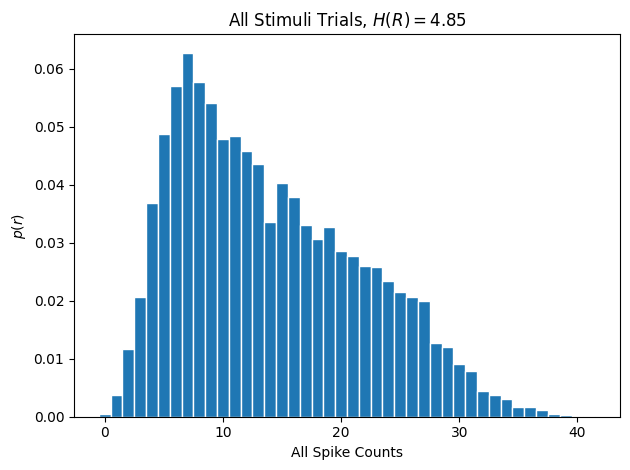

In [12]:
# Combine all responses to stimuli
all_counts = np.concatenate(all_spike_counts)

# Calculate p(r) for all spike counts
vals, freqs = np.unique(all_counts, return_counts=True)
p_r = freqs / freqs.sum()

# Calculate H(R)
h_r = -(p_r * np.log2(p_r)).sum()

# Plot histogram of all spike counts
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.bar(vals, p_r, width=1, edgecolor="w")
ax.set_title(f"All Stimuli Trials, $H(R)={h_r:.02f}$")
ax.set_xlabel("All Spike Counts")
ax.set_ylabel("$p(r)$")
plt.show()

By definition, the mutual information is the reduction in uncertainty about a stimulus $S$ after observing a response $R$:

$I(S;R) = H(S) - H(S|R) = H(R) - H(R|S)$

In [13]:
# Determine mutual information
mutual_information = h_r - h_r_given_s
mutual_information

np.float64(1.0330428827960714)

How does mutual information change with two equally likely stimuli of different rates? In otherwords, how does mutual information change depending on overlap of response distributions from two different stimuli?

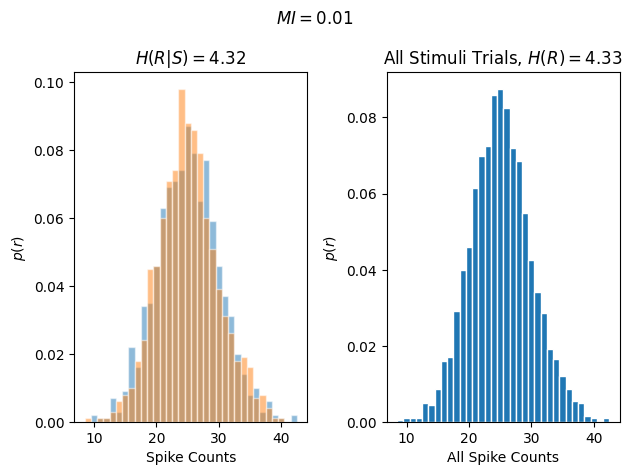

In [19]:
# Rates and likelihood of stimuli
stimuli_rates = [25, 25]
p_s = [0.5, 0.5]
N_trials = 1000

# Calculate all spike counts
all_spike_counts = []
for rate in stimuli_rates:
    all_spike_counts.append(spike_counts(generate_trains(rate, N_trials, T)))

# Set up figure to visualize histgorams
fig, ax = plt.subplots(1, 2, tight_layout=True)
axes = [ax[i] for i in range(2)]

# Iterate through stimuli and determine H(R|S)
h_r_given_s = 0
for i, priors in enumerate(p_s):

    # Determine p(r) for each stimulus
    vals, freqs = np.unique(all_spike_counts[i], return_counts=True)
    p_r = freqs / freqs.sum()

    # Plot p(r)
    axes[0].bar(vals, p_r, width=1, edgecolor="w", alpha=0.5)
    axes[0].set_xlabel("Spike Counts")
    axes[0].set_ylabel("$p(r)$")

    # Update H(R|S) with each contribution from stimuli s_i
    h_r_given_s += -(p_r * np.log2(p_r)).sum() * priors
axes[0].set_title(f"$H(R|S) = {h_r_given_s:.02f}$")

# Combine all responses
all_counts = np.concatenate(all_spike_counts)

# Calculate p(r) for all spike counts
vals, freqs = np.unique(all_counts, return_counts=True)
p_r = freqs / freqs.sum()

# Determine H(R) based on p(r)
h_r = -(p_r * np.log2(p_r)).sum()

# Plot histogram of all spike counts and determine mutual information
axes[1].bar(vals, p_r, width=1, edgecolor="w")
axes[1].set_title(f"All Stimuli Trials, $H(R)={h_r:.02f}$")
axes[1].set_xlabel("All Spike Counts")
axes[1].set_ylabel("$p(r)$")
plt.suptitle(f"$MI = {h_r-h_r_given_s:.02f}$")
plt.show()